In [2]:
import sys
sys.path.append('../')
path_data = '/home/jaime/projects/Dropbox_project/projects/kaggle/Housing_prices_course/data/'

In [23]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import SplineTransformer

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import warnings
import importlib
warnings.filterwarnings('ignore')
%matplotlib inline

In [71]:
def type_and_nulls(df):
    df_type = pd.concat([pd.DataFrame(df.dtypes), df.isnull().sum().to_frame().rename(columns={0:'nulls'})], axis=1)
    display(df_type.head())
    display(df.dtypes.value_counts())
    not_nulls = list((df_type[df_type['nulls']==0]).index)
    nulls = list((df_type[df_type['nulls']>0]).index)
    
    dict_type_columns = {}
    for type_column in list(df.dtypes.value_counts().index):
        dict_type_columns[str(type_column)] = list(df_type[df_type[0] == type_column].index)
    
    print('Nulls features: ', len(nulls))
    print('Not null features: ', len(not_nulls))
    
    dict_type_columns['nulls'] = nulls
    dict_type_columns['not_nulls'] = not_nulls
    
    
    return dict_type_columns, df_type


def correlation_heatmap(df, columns, figsize=(12, 9), plot=False):
    corrmat = df[columns].corr()
    sorted_columns = corrmat.sum(axis=1).sort_values().index.values
    corrmat = corrmat.loc[sorted_columns][sorted_columns]
    if plot:
        f, ax = plt.subplots(figsize=figsize)
        sns.heatmap(corrmat, vmax=.8, square=True)
    return corrmat

def polynomial_transformations(df_train, columns, degree=2, scale_method=None):
    if scale_method is not None:
        df_train, df_val = apply_scale(df_train[columns], df_val[columns], scale_method)
    poly_trans = PolynomialFeatures(degree=degree)
    df_result_train = pd.DataFrame(poly_trans.fit_transform(df_train[columns]))
        
    df_result_train.columns = poly_trans.get_feature_names_out()
    
    return df_result_train

In [5]:
df_train = pd.read_csv(path_data+'train.csv', index_col='Id')
df_test = pd.read_csv(path_data+'test.csv', index_col='Id')

In [6]:
dict_type_columns, df_type = type_and_nulls(df_train)

,0,nulls
MSSubClass,int64,0
MSZoning,object,0
LotFrontage,float64,259
LotArea,int64,0
Street,object,0


object     43
int64      34
float64     3
dtype: int64

Nulls features:  19
Not null features:  61


In [7]:
numerical_features_not_null = set(dict_type_columns['int64'] + dict_type_columns['float64']) - set(dict_type_columns['nulls'])
numerical_features_not_null = list(numerical_features_not_null)
target = numerical_features_not_null.pop(numerical_features_not_null.index('SalePrice'))
len(numerical_features_not_null)
print(target)
print(len(numerical_features_not_null), numerical_features_not_null)

SalePrice
33 ['YearRemodAdd', 'MoSold', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'TotalBsmtSF', 'WoodDeckSF', 'TotRmsAbvGrd', 'MiscVal', 'LowQualFinSF', 'OpenPorchSF', 'EnclosedPorch', 'FullBath', 'HalfBath', 'LotArea', 'GarageCars', 'OverallCond', 'PoolArea', 'Fireplaces', 'OverallQual', 'ScreenPorch', '1stFlrSF', '2ndFlrSF', 'MSSubClass', 'BsmtUnfSF', 'YrSold', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF2', 'KitchenAbvGr', 'GarageArea', 'YearBuilt', 'BsmtFinSF1']


In [8]:
df_train[numerical_features_not_null].describe()

,YearRemodAdd,MoSold,GrLivArea,BsmtFullBath,BsmtHalfBath,TotalBsmtSF,WoodDeckSF,TotRmsAbvGrd,MiscVal,LowQualFinSF,...,MSSubClass,BsmtUnfSF,YrSold,3SsnPorch,BedroomAbvGr,BsmtFinSF2,KitchenAbvGr,GarageArea,YearBuilt,BsmtFinSF1
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,1984.865753,6.321918,1515.463699,0.425342,0.057534,1057.429452,94.244521,6.517808,43.489041,5.844521,...,56.897260,567.240411,2007.815753,3.409589,2.866438,46.549315,1.046575,472.980137,1971.267808,443.639726
std,20.645407,2.703626,525.480383,0.518911,0.238753,438.705324,125.338794,1.625393,496.123024,48.623081,...,42.300571,441.866955,1.328095,29.317331,0.815778,161.319273,0.220338,213.804841,30.202904,456.098091
min,1950.000000,1.000000,334.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,20.000000,0.000000,2006.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1872.000000,0.000000
25%,1967.000000,5.000000,1129.500000,0.000000,0.000000,795.750000,0.000000,5.000000,0.000000,0.000000,...,20.000000,223.000000,2007.000000,0.000000,2.000000,0.000000,1.000000,334.500000,1954.000000,0.000000
50%,1994.000000,6.000000,1464.000000,0.000000,0.000000,991.500000,0.000000,6.000000,0.000000,0.000000,...,50.000000,477.500000,2008.000000,0.000000,3.000000,0.000000,1.000000,480.000000,1973.000000,383.500000
75%,2004.000000,8.000000,1776.750000,1.000000,0.000000,1298.250000,168.000000,7.000000,0.000000,0.000000,...,70.000000,808.000000,2009.000000,0.000000,3.000000,0.000000,1.000000,576.000000,2000.000000,712.250000
max,2010.000000,12.000000,5642.000000,3.000000,2.000000,6110.000000,857.000000,14.000000,15500.000000,572.000000,...,190.000000,2336.000000,2010.000000,508.000000,8.000000,1474.000000,3.000000,1418.000000,2010.000000,5644.000000


In [189]:
target = 'SalePrice'

## Split training and test datasets
x_train, x_test = train_test_split(df_train[numerical_features_not_null+[target]], test_size=0.4, random_state=0)
y_train = x_train.pop(target)
y_test = x_test.pop(target)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((876, 33), (876,), (584, 33), (584,))

In [192]:
scaler = StandardScaler()

x_train = pd.DataFrame(scaler.fit_transform(x_train), index=x_train.index)
x_train.columns = numerical_features_not_null

x_test = pd.DataFrame(scaler.transform(x_test), index=x_test.index)
x_test.columns = numerical_features_not_null   

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((876, 33), (876,), (584, 33), (584,))

In [195]:
## computing correlation
num_best_features = 5
corr_target = correlation_heatmap(pd.concat([x_train, pd.DataFrame(y_train)], axis=1), 
                                  pd.concat([x_train, pd.DataFrame(y_train)], axis=1).columns)
high_corr_features_exp_1 = list(corr_target[target].sort_values(ascending=False)[1:num_best_features+1].index)
corr_target[target].sort_values(ascending=False)[1:num_best_features+1]

OverallQual    0.789707
GrLivArea      0.727386
GarageCars     0.647622
GarageArea     0.643518
TotalBsmtSF    0.633855
Name: SalePrice, dtype: float64

In [257]:
## final model experiment_1
list_metrics = [] 
for num_best_features in np.arange(1, x_train.shape[1]+1, 1):

    corr_target = correlation_heatmap(pd.concat([x_train, pd.DataFrame(y_train)], axis=1), 
                                      pd.concat([x_train, pd.DataFrame(y_train)], axis=1).columns)
    high_corr_features_exp_1 = list(corr_target[target].sort_values(ascending=False)[1:num_best_features+1].index)        
    
    df_train_tmp = x_train[high_corr_features_exp_1]
    df_test_tmp = x_test[high_corr_features_exp_1]
    
    lr = LinearRegression().fit(df_train_tmp.values, y_train.values)
    
    y_predict_train = lr.predict(df_train_tmp.values)
    y_predict_test = lr.predict(df_test_tmp.values)

    metric_train = mean_squared_error(y_predict_train, y_train.values)
    metric_test = mean_squared_error(y_predict_test, y_test.values)   
    
    df_polyn_train =  polynomial_transformations(df_train_tmp, high_corr_features_exp_1, degree=2)
    df_polyn_test =  polynomial_transformations(df_test_tmp, high_corr_features_exp_1, degree=2)
        
        
    lr = LinearRegression().fit(df_polyn_train.values, y_train.values)

    y_predict_train = lr.predict(df_polyn_train.values)
    y_predict_test = lr.predict(df_polyn_test.values)

    metric_train_pol = mean_squared_error(y_predict_train, y_train.values)
    metric_test_pol = mean_squared_error(y_predict_test, y_test.values)   
    
    list_metrics.append([metric_train, metric_test, metric_train_pol, metric_test_pol])    


<AxesSubplot:>

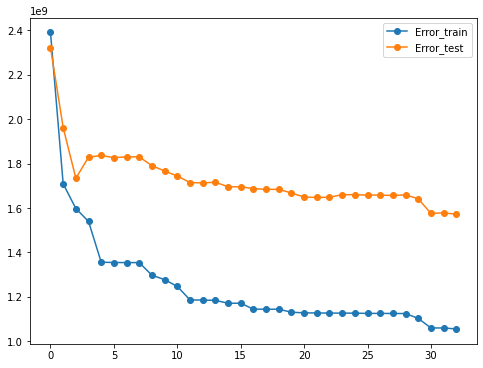

In [258]:
f, ax = plt.subplots(1, figsize=[8,6])
df_metrics = pd.DataFrame(list_metrics)
df_metrics.columns = ['Error_train', 'Error_test', 'Error_train_p', 'Error_test_p']
# df_metrics.plot(style='-o')
df_metrics.iloc[:,0:2].plot(style='-o', ax=ax)

<AxesSubplot:>

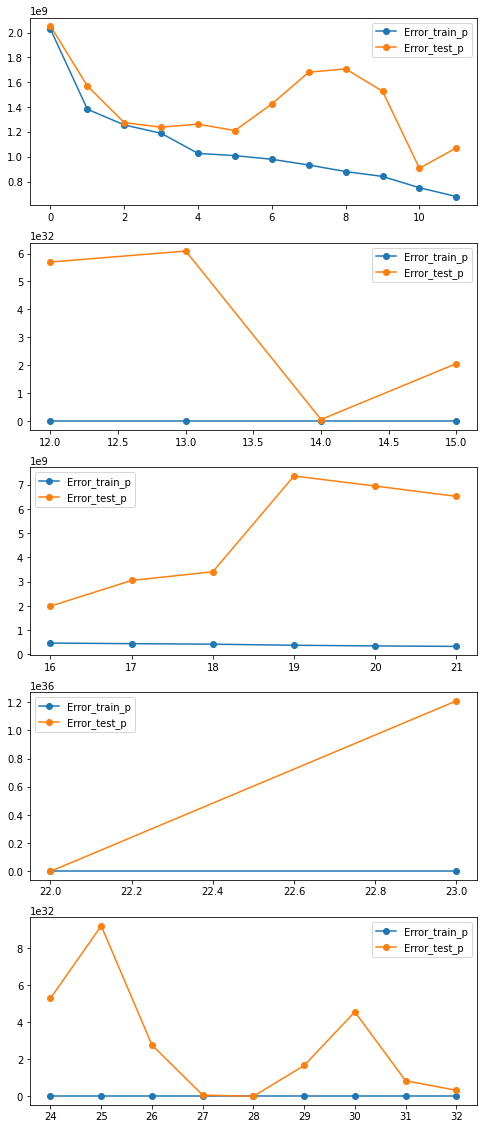

In [260]:
f, ax = plt.subplots(5, figsize=[8,20])
df_metrics = pd.DataFrame(list_metrics)
df_metrics.columns = ['Error_train', 'Error_test', 'Error_train_p', 'Error_test_p']
df_metrics.iloc[0:12,2:].plot(style='-o', ax=ax[0])
df_metrics.iloc[12:16,2:].plot(style='-o', ax=ax[1])
df_metrics.iloc[16:22,2:].plot(style='-o', ax=ax[2])
df_metrics.iloc[22:24,2:].plot(style='-o', ax=ax[3])
df_metrics.iloc[24:,2:].plot(style='-o', ax=ax[4])

In [261]:
df_metrics.describe()

,Error_train,Error_test,Error_train_p,Error_test_p
count,3.300000e+01,3.300000e+01,3.300000e+01,3.300000e+01
mean,1.252916e+09,1.727268e+09,6.455685e+08,3.676502e+34
std,2.566485e+08,1.374560e+08,4.199248e+08,2.105051e+35
min,1.054955e+09,1.572204e+09,1.839173e+08,9.066706e+08
25%,1.126301e+09,1.658243e+09,3.053754e+08,1.568997e+09
50%,1.144191e+09,1.687582e+09,5.696127e+08,6.946768e+09
75%,1.297113e+09,1.766852e+09,8.804484e+08,1.660836e+32
max,2.391092e+09,2.323005e+09,2.025926e+09,1.209380e+36


In [265]:
## Which iteration were minumun
print(np.argmin(df_metrics.values, axis=0))

## Which iteration were minumun
print(np.argmax(df_metrics.values, axis=0))

[32 32 32 10]
[ 0  0  0 23]
